# Bayesian Model Averaging Using the BIC

## Fitting a Uniform Distribution

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

# Data
y = [2, 3, 7, 8, 4, 5, 10, 15, 8, 6, 3, 11]

# Calculate the mean of the data (MLE for lambda in Poisson distribution)
mean_y = np.mean(y)
variance_y = np.var(y)

def fit_uniform(y):
    # Define the Uniform distribution PMF
    def uniform_pmf(k, n):
        k = np.asarray(k)  # Ensure k is a numpy array
        return [1 / n if j <= n else 0 for j in k]

    # Define the negative log-likelihood function for the Uniform distribution
    def neg_log_likelihood_uniform(params, data):
        n = params[0]  # Assuming n is the number of trials in the data
        pmf_values = uniform_pmf(data, n)
        # Avoid log(0) by replacing 0 with a very small number
        pmf_values = np.where(np.array(pmf_values) == 0, 1e-10, pmf_values)
        return -np.sum(np.log(pmf_values))

    n_range = range(1,np.max(y)*10)

    # Grid search for the best n
    best_n = None
    best_neg_log_likelihood = np.inf

    for n in n_range:
        # Initial guess for n
        initial_guess = np.array([n])
        # Minimize the negative log-likelihood
        result = minimize(neg_log_likelihood_uniform, initial_guess, args=(y,), bounds=[(1e-5, None)])

        if result.fun < best_neg_log_likelihood:
            best_neg_log_likelihood = result.fun
            best_n = result.x[0]

    # Extract the fitted parameter
    n_fitted = best_n

    # Calculate the log-likelihood of the model
    log_likelihood_uniform = -neg_log_likelihood_uniform([n_fitted], y)

    # Number of parameters (k) and number of data points (n)
    k = 1
    n = len(y)

    # Calculate BIC
    bic_uniform = k * np.log(n) - 2 * log_likelihood_uniform

    return log_likelihood_uniform, n_fitted, bic_uniform, uniform_pmf

log_likelihood_uniform, n_fitted_uniform, bic_uniform, uniform_pmf = fit_uniform(y)

print(f"Fitted n (maximal value): {round(n_fitted_uniform,1)}")
print(f"BIC for the Uniform model: {int(bic_uniform)}")

Fitted n (maximal value): 15.0
BIC for the Uniform model: 67


## Fitting a Poisson Model

In [2]:
import numpy as np
from scipy.stats import poisson

def fit_poi(y):
    λ = np.mean(y)  # MLE for λ in Poisson distribution
    # Calculate the log-likelihood of the Poisson model
    log_likelihood_poi = np.sum(poisson.logpmf(y, λ))

    # Number of parameters (k) and number of data points (n)
    k = 1
    n = len(y)

    # Calculate the Bayesian Information Criterion (BIC)
    bic_poi = k * np.log(n) - 2 * log_likelihood_poi

    return log_likelihood_poi, λ, bic_poi

log_likelihood_poi, λ, bic_poi = fit_poi(y)

print(f"Fitted λ (mean): {round(λ, 1)}")
print(f"BIC for the Poisson model: {int(bic_poi)}")

Fitted λ (mean): 6.8
BIC for the Poisson model: 69


## Fitting a Binomial Model

Fitted n (number of trials): 675
Fitted p (probability): 0.01
BIC for the Binomial model: 72


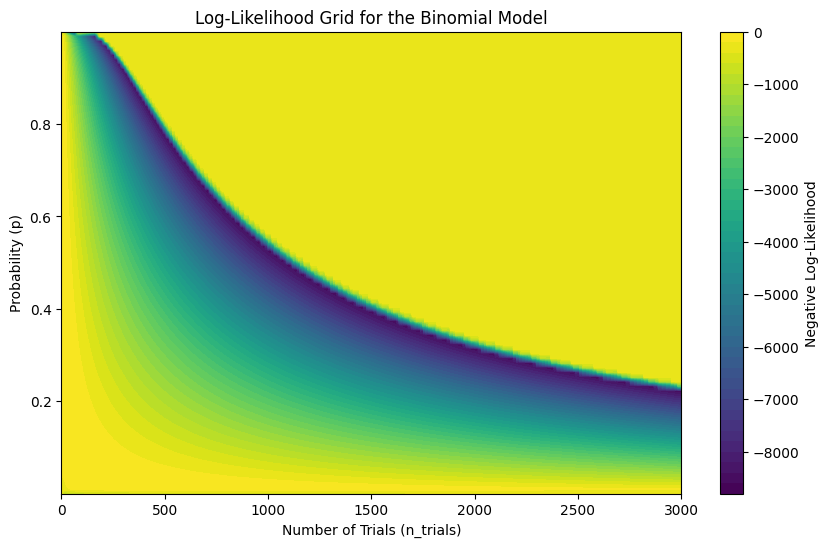

In [3]:
import numpy as np
from scipy.stats import binom

def fit_binom(y):
    # Define the negative log-likelihood function for the Binomial model
    def neg_log_likelihood_binom(params, y):
        n, p = params # Unpack the parameters
        pmf_values = binom.pmf(y, n, p)
        # Avoid log(0) by replacing 0 with a very small number
        pmf_values = np.where(np.array(pmf_values) == 0, 1e-10, pmf_values)
        result = -np.sum(np.log(pmf_values))
        return result

    # Define the grid of parameter ranges
    n_trials_range = np.arange(0, np.max(y)*200 + 1, 5)
    p_range = np.linspace(1e-5, 1 - 1e-5, 100)

    # Vectorized grid search for the best n and p
    n_grid, p_grid = np.meshgrid(n_trials_range, p_range, indexing='ij')
    log_likelihood_grid = np.zeros_like(n_grid, dtype=float)

    for i in range(n_grid.shape[0]):
        for j in range(n_grid.shape[1]):
            n = n_grid[i, j]
            p = p_grid[i, j]
            log_likelihood_grid[i, j] = -neg_log_likelihood_binom((np.array([n]),np.array([p])), np.array(y))
            pass

    # Mask out np.inf values by setting them to a very large number
    log_likelihood_grid[np.isinf(log_likelihood_grid)] = 1e10

    # Find the indices of the minimum negative log-likelihood
    min_idx = np.unravel_index(np.argmax(log_likelihood_grid), log_likelihood_grid.shape)
    n_fitted_binom = n_grid[min_idx]
    p_fitted_binom = p_grid[min_idx]
    best_neg_log_likelihood = log_likelihood_grid[min_idx]

    # Calculate the log-likelihood
    log_likelihood_binom = best_neg_log_likelihood

    # Number of parameters (k)
    k = 2

    # Number of data points (n)
    n = len(y)

    # Calculate BIC
    bic_binom = k * np.log(n) - 2 * log_likelihood_binom

    return log_likelihood_binom, n_fitted_binom, p_fitted_binom, bic_binom, n_grid, p_grid, log_likelihood_grid

log_likelihood_binom, n_fitted_binom, p_fitted_binom, bic_binom, n_grid_binom, p_grid_binom, log_likelihood_grid_binom = fit_binom(y)

print(f"Fitted n (number of trials): {n_fitted_binom}")
print(f"Fitted p (probability): {round(p_fitted_binom, 3)}")
print("BIC for the Binomial model:", int(bic_binom))

# Plot the log-likelihood grid
plt.figure(figsize=(10, 6))
plt.contourf(n_grid_binom, p_grid_binom, log_likelihood_grid_binom, levels=50, cmap='viridis')
plt.colorbar(label='Negative Log-Likelihood')
plt.xlabel('Number of Trials (n_trials)')
plt.ylabel('Probability (p)')
plt.title('Log-Likelihood Grid for the Binomial Model')
plt.show()

## Fitting a Negative Binomial

Fitted r (number of claims until stop): 7.1
Fitted p (probability of a claim): 0.51
BIC for the Negative Binomial model: 68


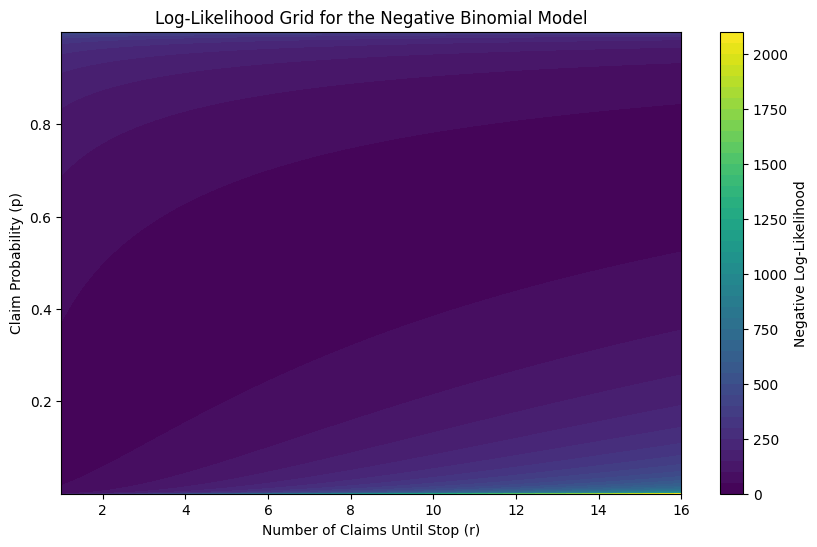

In [4]:
import numpy as np
from scipy.stats import nbinom
from scipy.optimize import minimize
from joblib import Parallel, delayed

def fit_nb(y):
    # Define the negative log-likelihood function for the Negative Binomial distribution
    def neg_log_likelihood_nb(params, y):
        r, p = params # Unpack the parameters
        pmf_values = nbinom.pmf(y, r, p)
        # Avoid log(0) by replacing 0 with a very small number
        pmf_values = np.where(np.array(pmf_values) == 0, 1e-10, pmf_values)
        result = -np.sum(np.log(pmf_values))
        return result

    # Define the grid of parameter ranges
    r_range = np.linspace(1, np.max(y) + 1, 100)  # Adjusted range for r
    p_range = np.linspace(1e-5, 1 - 1e-5, 1000)  # Adjusted range for p

    # Initialize an empty matrix to store the results
    log_likelihood_matrix = np.zeros((len(r_range), len(p_range)))

    # Function to perform optimization for a given r
    def optimize_for_r(i, r, y):
        best_p = None
        best_neg_log_likelihood = np.inf
        local_log_likelihood_matrix = np.zeros(len(p_range))
        for j, p in enumerate(p_range):
            initial_guess = np.array([r, p])
            result = neg_log_likelihood_nb(initial_guess, y)
            # result = minimize(neg_log_likelihood_nb, initial_guess, args=(y,), bounds=[(1e-5, None), (1e-5, 1-1e-5)])

            # Store the results in the local matrix
            local_log_likelihood_matrix[j] = result

            if result < best_neg_log_likelihood:
                best_neg_log_likelihood = result
                best_p = p
        return i, local_log_likelihood_matrix, r, best_p, best_neg_log_likelihood

    # Parallel processing to optimize for each r
    results = Parallel(n_jobs=-2)(delayed(optimize_for_r)(i, r, y) for (i, r) in enumerate(r_range))

    # Update the global log_likelihood_matrix with results from parallel processing
    for result in results:
        i, local_log_likelihood_matrix, r, best_p, best_neg_log_likelihood = result
        log_likelihood_matrix[i, :] = local_log_likelihood_matrix

    # Find the best parameters from the results
    best_result = min(results, key=lambda x: x[4])
    best_r, best_p, best_neg_log_likelihood = best_result[2], best_result[3], best_result[4]

    r_nb_fitted = best_r
    p_nb_fitted = best_p

    # Calculate the log-likelihood
    log_likelihood_nb = best_neg_log_likelihood

    # Number of parameters (k) and number of data points (n)
    k = 2
    n = len(y)

    # Calculate BIC
    bic_nb = k * np.log(n) + 2 * log_likelihood_nb

    return log_likelihood_nb, r_nb_fitted, p_nb_fitted, bic_nb, r_range, p_range, log_likelihood_matrix

log_likelihood_nb, r_nb_fitted, p_nb_fitted, bic_nb, r_range_nb, p_range_nb, log_likelihood_matrix_nb = fit_nb(y)

# Print the fitted parameters
print(f"Fitted r (number of claims until stop): {round(r_nb_fitted,1)}")
print(f"Fitted p (probability of a claim): {round(p_nb_fitted,2)}")
print("BIC for the Negative Binomial model:", int(bic_nb))

# Plot the log-likelihood grid
plt.figure(figsize=(10, 6))
plt.contourf(r_range_nb, p_range_nb, log_likelihood_matrix_nb.T, levels=50, cmap='viridis')
plt.colorbar(label='Negative Log-Likelihood')
plt.xlabel('Number of Claims Until Stop (r)')
plt.ylabel('Claim Probability (p)')
plt.title('Log-Likelihood Grid for the Negative Binomial Model')
plt.show()

## Fitting a Beta-Binomial

In [5]:
import numpy as np
from scipy.special import betaln, comb
from scipy.optimize import minimize

def fit_beta_binom(y):
    # Define the Beta-Binomial PMF
    def beta_binomial_pmf(k, n, alpha, beta):
        k = np.asarray(k)  # Ensure k is a numpy array
        binom_coeff = comb(n, k)  # Calculate the binomial coefficient
        pmf = binom_coeff * np.exp(betaln(k + alpha, n - k + beta) - betaln(alpha, beta))
        return pmf

    # Define the negative log-likelihood function for the Beta-Binomial distribution
    def neg_log_likelihood_bb(params, data):
        alpha, beta = params
        n = max(data)  # Assuming n is the maximal value in the data
        return -np.sum(np.log(beta_binomial_pmf(data, n, alpha, beta)))

    # Initial guesses for alpha and beta
    initial_params = [1, 1]

    # Fit the Beta-Binomial distribution to the data
    model_bb = minimize(neg_log_likelihood_bb, initial_params, args=(y,), bounds=[(1e-5, None), (1e-5, None)])

    # Extract the fitted parameters
    alpha_bb_fitted, beta_bb_fitted = model_bb.x

    # Calculate the log-likelihood of the model
    log_likelihood_bb = -neg_log_likelihood_bb((alpha_bb_fitted, beta_bb_fitted), y)

    # Number of parameters (k) and number of data points (n)
    k = 2
    n = len(y)

    # Calculate BIC
    bic_bb = k * np.log(n) - 2 * log_likelihood_bb

    return log_likelihood_bb, alpha_bb_fitted, beta_bb_fitted, bic_bb, beta_binomial_pmf

log_likelihood_bb, alpha_bb_fitted, beta_bb_fitted, bic_bb, beta_binomial_pmf = fit_beta_binom(y)

print(f"Fitted α (expected number of successes): {round(alpha_bb_fitted,1)}")
print(f"Fitted β (expected number of failures): {round(beta_bb_fitted,1)}")
print("BIC for the Beta-Binomial model:", int(bic_bb))

Fitted α (expected number of successes): 1.9
Fitted β (expected number of failures): 2.2
BIC for the Beta-Binomial model: 69


## Fitting the Empirical Distribution

In [6]:
import numpy as np
from collections import Counter

def fit_empirical(y):
    # Calculate the frequency of each value in the observed data
    frequency_counts = Counter(y)

    # Normalize the frequencies to get probabilities
    total_count = sum(frequency_counts.values())
    probabilities = {k: v / total_count for k, v in frequency_counts.items()}

    # Create the predictive distribution
    def predictive_distribution(value):
        return probabilities.get(value, 0)

    # Calculate the log-likelihood of the observed data
    log_likelihood = np.sum([np.log(predictive_distribution(val)) for val in y])

    # Number of parameters (k) and number of data points (n)
    k = len(y)
    n = len(y)

    # Calculate BIC
    bic_emp = k * np.log(n) - 2 * log_likelihood

    return log_likelihood, probabilities, bic_emp, predictive_distribution

log_likelihood_emp, emp_probabilities, bic_emp, predictive_distribution = fit_empirical(y)

print("BIC for the Empirical distribution:",  int(bic_emp))

BIC for the Empirical distribution: 83


## Model Averaging Using the Bayesian Information Criterion (BIC)

In [7]:
# Calculate the weights for each model based on their BIC values
bic_values = np.array([bic_uniform, bic_poi, bic_binom, bic_nb, bic_bb, bic_emp])
min_bic = np.min(bic_values)
delta_bic = bic_values - min_bic
weights = np.exp(-0.5 * delta_bic) / np.sum(np.exp(-0.5 * delta_bic))

# Print the weights for each model
print("Weights:")
print(f" - Uniform = {int(round(weights[0], 2)*100)}%")
print(f" - Poisson = {int(round(weights[1], 2)*100)}%")
print(f" - Binomial = {int(round(weights[2], 2)*100)}%")
print(f" - Negative Binomial = {int(round(weights[3], 2)*100)}%")
print(f" - Beta-Binomial = {int(round(weights[4], 2)*100)}%")
print(f" - Empirical = {int(round(weights[5], 2)*100)}%")

# Calculate the weighted average of the models
x = np.arange(0, max(y) + 1)

# Uniform PMF
uniform_pmf_values = uniform_pmf(x, n_fitted_uniform)
uniform_pmf_values = np.array(uniform_pmf_values)  # Convert to NumPy array before multiplication

# Poisson PMF
poisson_pmf = poisson.pmf(x, mean_y)

# Binomial PMF
binomial_pmf = binom.pmf(x, n_fitted_binom, p_fitted_binom)

# Negative Binomial PMF
nbinom_pmf = nbinom.pmf(x, r_nb_fitted, p_nb_fitted)

# Beta-Binomial PMF
beta_binom_pmf = beta_binomial_pmf(x, max(y), alpha_bb_fitted, beta_bb_fitted)

# Empirical PMF
empirical_pmf = np.array([predictive_distribution(val) for val in x])

# Weighted average PMF
average_pmf = (weights[0] * uniform_pmf_values +
               weights[1] * poisson_pmf +
               weights[2] * binomial_pmf +
               weights[3] * nbinom_pmf +
               weights[4] * beta_binom_pmf +
               weights[5] * empirical_pmf)

# Calculate the log-likelihood of the averaged model
log_likelihood_bma = np.sum(np.log(average_pmf[y]))

# Number of parameters for each model
num_parameters_uniform = 1  # Uniform
num_parameters_poi = 1  # Poisson
num_parameters_binom = 2  # Binomial
num_parameters_nb = 2   # Negative Binomial
num_parameters_bb = 2   # Beta-Binomial
num_parameters_emp = len(y)  # Empirical

# Calculate the weighted average of the number of parameters
num_parameters = (weights[0] * num_parameters_uniform +
                  weights[1] * num_parameters_poi +
                  weights[2] * num_parameters_binom +
                  weights[3] * num_parameters_nb +
                  weights[4] * num_parameters_bb +
                  weights[5] * num_parameters_emp)

print(f"Number of parameters in the averaged model: {round(num_parameters,1)}")

# Number of data points
n = len(y)

# Calculate BIC
bic_averaged_model = num_parameters * np.log(n) - 2 * log_likelihood_bma

print(f"BIC of the averaged model: {int(bic_averaged_model)}")

Weights:
 - Uniform = 41%
 - Poisson = 16%
 - Binomial = 4%
 - Negative Binomial = 25%
 - Beta-Binomial = 14%
 - Empirical = 0%
Number of parameters in the averaged model: 1.4
BIC of the averaged model: 66


## Visualizing the Different Models

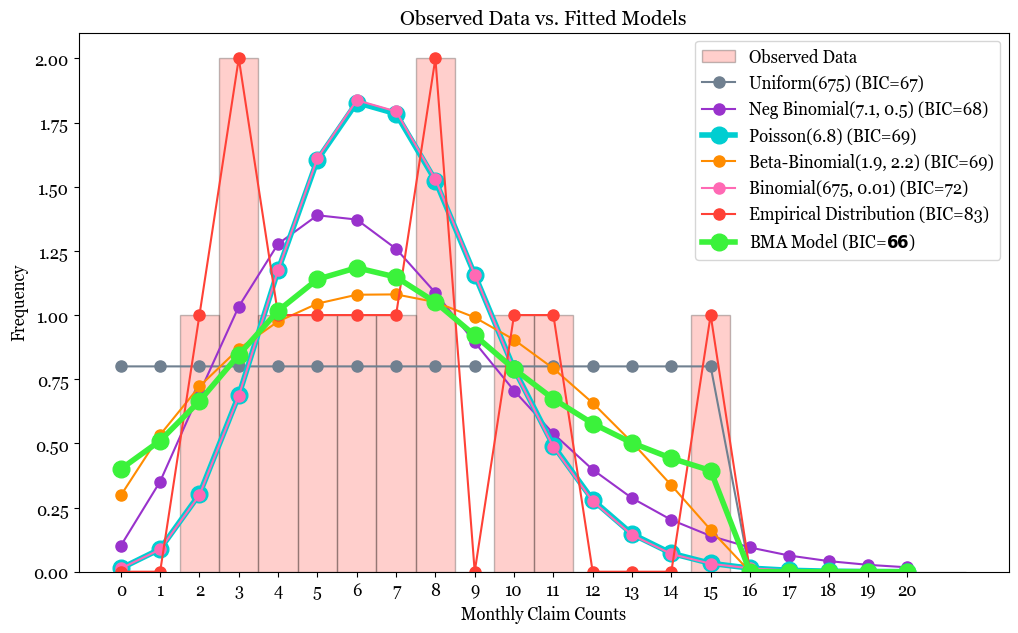

In [8]:
# Set the font properties
plt.rcParams['font.family'] = 'Georgia'
plt.rcParams['font.size'] = 12

# Plot the observed data as a histogram
plt.figure(figsize=(12, 7))
plt.hist(y, bins=np.arange(min(y)-0.5, 21 + 1.5), alpha=0.25, color='#FF4136', edgecolor='black', label='Observed Data')

x = np.arange(0, 21)

# Calculate the expected Uniform probabilities
uniform_pmf_values = uniform_pmf(x, n_fitted_uniform)
uniform_pmf_values = [x * len(y) for x in uniform_pmf_values]

# Overlay the fitted Uniform distribution
plt.plot(x, uniform_pmf_values, 'o-', label=f'Uniform({round(n_fitted_binom,1)}) (BIC={int(bic_uniform)})', color='#708090', markersize=8)

# Calculate the expected Negative Binomial probabilities
nbinom_pmf = nbinom.pmf(x, r_nb_fitted, p_nb_fitted) * len(y)

# Overlay the fitted Negative Binomial distribution
plt.plot(x, nbinom_pmf, 'o-', label=f'Neg Binomial({round(r_nb_fitted,1)}, {round(p_nb_fitted,1)}) (BIC={int(bic_nb)})', color='#9932CC', markersize=8)

# Overlay the fitted Poisson distribution
poisson_pmf = poisson.pmf(x, mean_y) * len(y)
plt.plot(x, poisson_pmf, 'o-', label=f'Poisson({round(mean_y,1)}) (BIC={int(bic_poi)})', color='#00CED1', markersize=12, linewidth=4)

# Calculate the expected Beta-Binomial probabilities
beta_binom_pmf = beta_binomial_pmf(x, max(y), alpha_bb_fitted, beta_bb_fitted) * len(y)

# Overlay the fitted Beta-Binomial distribution
plt.plot(x, beta_binom_pmf, 'o-', label=f'Beta-Binomial({round(alpha_bb_fitted,1)}, {round(beta_bb_fitted,1)}) (BIC={int(bic_bb)})', color='#FF8C00', markersize=8)

# Calculate the expected Binomial probabilities
binom_pmf = binom.pmf(x, n_fitted_binom, p_fitted_binom) * len(y)

# Overlay the fitted Binomial distribution
plt.plot(x, binom_pmf, 'o-', label=f'Binomial({n_fitted_binom}, {round(p_fitted_binom, 3)}) (BIC={int(bic_binom)})', color='#FF69B4', markersize=8)

# Calculate the empirical probabilities
empirical_pmf = np.array([emp_probabilities.get(val, 0) for val in x]) * len(y)

# Overlay the empirical distribution
plt.plot(x, empirical_pmf, 'o-', label=f'Empirical Distribution (BIC={int(bic_emp)})', color='#FF4136', markersize=8)

# Overlay the weighted average model (unhighlighted color is #32CD32)
plt.plot(x, np.pad(average_pmf, (0, 5), 'constant') * len(y), 'o-', label=f'BMA Model (BIC=$\\mathbf{{{int(bic_averaged_model)}}}$)', color='#3BF23B', markersize=12, linewidth=4)

# Set x-axis labels for every element
plt.xticks(np.arange(0, 21))

plt.title('Observed Data vs. Fitted Models')
plt.xlabel('Monthly Claim Counts')
plt.ylabel('Frequency')
plt.legend()
plt.show()